1. Implement L2 regularization on cat-dog classification neural network. Train the model on the dataset, and observe the impact of the regularization on the weight parameters. (Do not use data augmentation).
a. L2 regularization using optimizer’s weight decay
b. L2 regularization using loop to find L2 norm of weights

In [51]:
import torch
from torch import nn
import torchvision
from torchvision import datasets,transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.models import alexnet,AlexNet_Weights
from torch.utils.data import Dataset,DataLoader,default_collate

In [52]:
#!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
#!unzip cats_and_dogs_filtered.zip
#!pip install torchinfo

In [53]:
weights = AlexNet_Weights.DEFAULT
weights

AlexNet_Weights.IMAGENET1K_V1

In [54]:
def custom_collate(batch):
    max_height = max(sample[0].shape[1] for sample in batch)
    max_width = max(sample[0].shape[2] for sample in batch)

    padded_batch = []
    for sample in batch:
        input_data, target = sample
        pad_height = max_height - input_data.shape[1]
        pad_width = max_width - input_data.shape[2]
        padded_input_data = torch.nn.functional.pad(input_data, (0, pad_width, 0, pad_height))
        padded_batch.append((padded_input_data, target))

    return default_collate(padded_batch)


In [55]:
train_dataset = ImageFolder(root='/content/cats_and_dogs_filtered/train',transform=ToTensor(),target_transform=None)
test_dataset = ImageFolder(root='/content/cats_and_dogs_filtered/validation',transform=ToTensor())
train_loader = DataLoader(dataset = train_dataset,batch_size = 32,shuffle=True,collate_fn=custom_collate)
test_loader = DataLoader(dataset = test_dataset,batch_size = 32,collate_fn=custom_collate)
class_names = train_dataset.classes
print(f"Number of classes:{len(class_names)}")

Number of classes:2


In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [57]:
model = alexnet(weights=weights).to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [58]:
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     23,296               True
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    307,392              True
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6)     

In [59]:
for param in model.parameters():
    param.requires_grad = False

In [60]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
output_shape = len(class_names)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features,output_shape,bias=True)).to(device)

In [61]:
summary(model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6

Part a Pytorch's inbuild weight decay parameter in optimizer

In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.001)

In [63]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [64]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    train_step(model,train_loader,loss_fn,optimizer,device)
    test_step(model,test_loader,loss_fn,device)

Epoch 0:------
Train Loss: 0.3869 | Train Accuracy: 0.8224
Test Loss: 0.3127 | Test Accuracy: 0.8594
Epoch 1:------
Train Loss: 0.2982 | Train Accuracy: 0.8705
Test Loss: 0.2647 | Test Accuracy: 0.8799
Epoch 2:------
Train Loss: 0.2678 | Train Accuracy: 0.8854
Test Loss: 0.2300 | Test Accuracy: 0.9023
Epoch 3:------
Train Loss: 0.2609 | Train Accuracy: 0.8934
Test Loss: 0.2514 | Test Accuracy: 0.8857
Epoch 4:------
Train Loss: 0.2710 | Train Accuracy: 0.8874
Test Loss: 0.2064 | Test Accuracy: 0.9150


Part b manually performing L2 regularization

In [65]:
manual_optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [66]:
lambda_ = 0.001
epochs = 5

In [67]:
def manual_train_step(model, dataloader, loss_fn, optimizer, device, lambda_):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)

        l2_reg = 0.0
        for param in model.parameters():
            l2_reg = torch.norm(param,p=2)**2

        loss += 0.5*lambda_*l2_reg
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def manual_test_step(model,dataloader,loss_fn,device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [68]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    manual_train_step(model,train_loader,loss_fn,manual_optimizer,device,lambda_)
    manual_test_step(model,test_loader,loss_fn,device)

Epoch 0:------
Train Loss: 0.5706 | Train Accuracy: 0.8338
Test Loss: 0.8508 | Test Accuracy: 0.7910
Epoch 1:------
Train Loss: 0.5093 | Train Accuracy: 0.8651
Test Loss: 0.3156 | Test Accuracy: 0.8955
Epoch 2:------
Train Loss: 0.6093 | Train Accuracy: 0.8522
Test Loss: 0.3588 | Test Accuracy: 0.9023
Epoch 3:------
Train Loss: 0.5554 | Train Accuracy: 0.8686
Test Loss: 0.2841 | Test Accuracy: 0.9102
Epoch 4:------
Train Loss: 0.4675 | Train Accuracy: 0.8755
Test Loss: 0.3494 | Test Accuracy: 0.8975


In [69]:
from PIL import Image
import matplotlib.pyplot as plt

def pred_and_plot_image(model, image_path, class_names, device='cuda'):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    model.to(device)
    model.eval()
    with torch.no_grad():
        transformed_image = transform(img).unsqueeze(dim=0).to(device)
        target_image_pred = model(transformed_image)

        predicted_class_index = torch.argmax(target_image_pred, dim=1).item()
        predicted_class = class_names[predicted_class_index]

        plt.imshow(img)
        plt.title(f"Predicted class: {predicted_class}")
        plt.axis('off')
        plt.show()

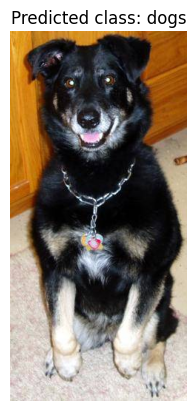

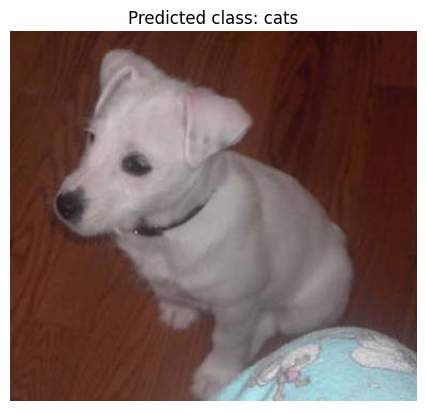

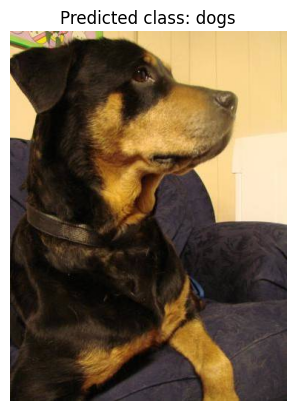

In [71]:
import random
from pathlib import Path
num = 3
test_path = Path('/content/cats_and_dogs_filtered/validation')
test_path_list = list(test_path.glob("*/*.jpg"))
test_image_sample =  random.sample(population=test_path_list,
                               k=num)
for image_path in test_image_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names = class_names)

2. Implement L1 regularization on cat-dog classification neural network. Train the model on the dataset, and observe the impact of the regularization on the weight parameters. (Do not use data augmentation).
a. L1 regularization using optimizer’s weight decay
b. L1regularization using loop to find L1 norm of weights

Part a L1 regularization using optimizer’s weight decay

In [72]:
l1_optimizer = torch.optim.Adam(params = model.parameters(),lr=0.01,weight_decay=0.01)

In [73]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    train_step(model,train_loader,loss_fn,l1_optimizer,device)
    test_step(model,test_loader,loss_fn,device)

Epoch 0:------
Train Loss: 0.5306 | Train Accuracy: 0.8690
Test Loss: 0.4097 | Test Accuracy: 0.8828
Epoch 1:------
Train Loss: 0.6676 | Train Accuracy: 0.8433
Test Loss: 0.4301 | Test Accuracy: 0.8867
Epoch 2:------
Train Loss: 0.6656 | Train Accuracy: 0.8532
Test Loss: 0.5097 | Test Accuracy: 0.8740
Epoch 3:------
Train Loss: 0.4380 | Train Accuracy: 0.8790
Test Loss: 0.3091 | Test Accuracy: 0.8936
Epoch 4:------
Train Loss: 0.4686 | Train Accuracy: 0.8656
Test Loss: 0.5685 | Test Accuracy: 0.8350


Part b L1 regularization using loop to find L1 norm of weights

In [74]:
def manual_train_step(model, dataloader, loss_fn, optimizer, device, lambda_):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)

        l1_reg = 0.0
        for param in model.parameters():
            l1_reg = torch.norm(param,p=1)**2

        loss += 0.5*lambda_*l1_reg
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def manual_test_step(model,dataloader,loss_fn,device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [75]:
torch.manual_seed(42)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    train_step(model,train_loader,loss_fn,manual_optimizer,device)
    test_step(model,test_loader,loss_fn,device)

Epoch 0:------
Train Loss: 0.4644 | Train Accuracy: 0.8750
Test Loss: 0.3350 | Test Accuracy: 0.9062
Epoch 1:------
Train Loss: 0.7682 | Train Accuracy: 0.8408
Test Loss: 0.4479 | Test Accuracy: 0.8896
Epoch 2:------
Train Loss: 0.7856 | Train Accuracy: 0.8542
Test Loss: 0.5069 | Test Accuracy: 0.8955
Epoch 3:------
Train Loss: 0.4274 | Train Accuracy: 0.8929
Test Loss: 0.4039 | Test Accuracy: 0.9062
Epoch 4:------
Train Loss: 0.4198 | Train Accuracy: 0.8874
Test Loss: 0.3906 | Test Accuracy: 0.9023


3. Implement dropout regularization on cat-dog classification neural network. Train the model with and without dropout on a dataset, and compare the performance and overfitting tendencies.

In [81]:
class CatDogClf(nn.Module):
    def __init__(self,dropout_prob=0.0):
        super().__init__()
        self.alexnet = model
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self,x):
        x = self.alexnet(x)


auto_transform = weights.transforms()
train_data = ImageFolder(root='/content/cats_and_dogs_filtered/train',transform=auto_transform)
test_data = ImageFolder(root='/content/cats_and_dogs_filtered/validation',transform=auto_transform)
train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=32)

model = CatDogClf().to(device)
model

CatDogClf(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
     